# TDT17 - Main notebook

This notebook contains the main code for the TDT17 project. See `preprocessing.ipynb` for the preprocessing code.
We now assume that the `yolov5` repository is cloned in the same directory as this notebook, and that the data is located
in the `yolodata` directory. `yolov5` assumes a `road_crack.yaml` file in the `yolov5/data` directory, which we recite below. 
This file tells the model where to find the data, and the classes to be used. It also assumes a `.pt` file which tells 
the model what kind of pretrained weights to use. We use `yolov5s.pt` in  this project, as it is small, but not too small.

```yaml
# road_crack.yaml
path: ../yolodata/train 
train: images/train  
val: images/val  
test: "submission.txt" 

names:
  0: DOO
  1: D10
  2: D20
  3: D40
```

Before going further in this notebook, a model has to be trained and saved. This is done in the command line, and 
when it is done, the model is loaded and used for the rest of the notebook. To train the model, assuming that 
everything is where it needs to be, run the following command:

```c#
  python train.py --img 500 --batch 8 --epochs 5 --data road_crack.yaml --weights yolov5s.pt --device 0 --workers 0
```

When the model is trained, we can use it to get predictions for the testset. This is done with the following command:

```c#
  python detect.py --img 500 --weights runs/train/exp/weights/last.pt --source ../yolodata/test/images --save-txt
```

This creates a `runs/detect/exp` directory, which contains the predictions for the testset. We can now access this
directory, and its contents. First we import the necessary libraries. Then we translate the predictions into a
format that will be easier to work with down the line. We chose a dictionary with the following format:

```python
  {'image': 'Norway_008163.jpg',
   'bboxes': [{
      'type': 0,
      'x': 0.409827,
      'y': 0.694512,
      'w': 0.0269009,
      'h': 0.133758
      }
    ]
 },
```

In [81]:
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random

class_names = {
    0: "D00",
    1: "D10",
    2: "D20",
    3: "D40",
}
labels_dir = "./yolov5/runs/detect/exp/labels/"
labels = os.listdir(labels_dir)
images_dir = "./Norway/test/images"
images = os.listdir(images_dir)
output_dicts = []
for i, image in enumerate(tqdm(images)):
    output_dict = {}
    output_dict["image"] = image
    bboxes = []
    if image.replace(".jpg", ".txt") in labels:
        with open(labels_dir + image.replace(".jpg", ".txt"), "r") as f:
            for line in f.readlines():
                bbox = {}
                line = line.split()
                bbox["type"] = int(line[0])
                bbox["x"] = float(line[1])
                bbox["y"] = float(line[2])
                bbox["w"] = float(line[3])
                bbox["h"] = float(line[4])
                bboxes.append(bbox)
    output_dict["bboxes"] = bboxes
    output_dicts.append(output_dict)

100%|██████████| 2040/2040 [00:00<00:00, 51241.03it/s]


#### Translating back to the original data format

As the YOLO data format uses `(x, y, w, h)` coordinates, we need to translate these back to the original format, which
was `(xmin, ymin, xmax, ymax)`. We will also need to add `1` to the `type` field, as the YOLO model is 0-indexed,
while the submission format is 1-indexed. We also need to translate the coordinates back to the original image size,
which is different for each image.

In [64]:
def upscale_bbox_corners(bbox, image_width, image_height):
    """
        Translates from `(x, y, w, h)` to `(xmin, ymin, xmax, ymax)`
    """
    x = bbox["x"]
    y = bbox["y"]
    w = bbox["w"]
    h = bbox["h"]
    xmin = int((x - w / 2) * image_width)
    ymin = int((y - h / 2) * image_height)
    xmax = int((x + w / 2) * image_width)
    ymax = int((y + h / 2) * image_height)
    return xmin, ymin, xmax, ymax

def create_prediction_string(bboxes):
    """
        Creates a prediction string in the format required by the competition.
    """
    pred_strings = []
    for bbox in bboxes:
        pred_strings.append(f"{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}")
    return " ".join(pred_strings)

# Submission dataframe
df = pd.DataFrame()

# Translating from dictionary to dataframe worthy format
for i, output_dict in enumerate(tqdm(output_dicts)):
    image_path = images_dir + "/" + output_dict["image"]
    image = Image.open(image_path)
    image_width, image_height = image.size
    boxes = []
    for bbox in output_dict["bboxes"]:
        xmin, ymin, xmax, ymax = upscale_bbox_corners(bbox, image_width, image_height)
        boxes.append([bbox["type"] + 1, xmin, ymin, xmax, ymax])
    df.loc[i, "ImageId"] = output_dict["image"]
    df.loc[i, "PredictionString"] = create_prediction_string(boxes)

# Creating submission file
df.to_csv("submission.csv", index=False, header=False)
    

100%|██████████| 2040/2040 [00:00<00:00, 3106.90it/s]


#### Displaying 5 images with predicted bounding boxes

Below you can see 5 images with predicted bounding boxes. The bounding boxes are colored according to the type of crack
they represent. The bounding boxes are also labeled with the type of crack they represent. It it upscaled to the
original size of the image to show that the upscaled bounding boxes are correct.

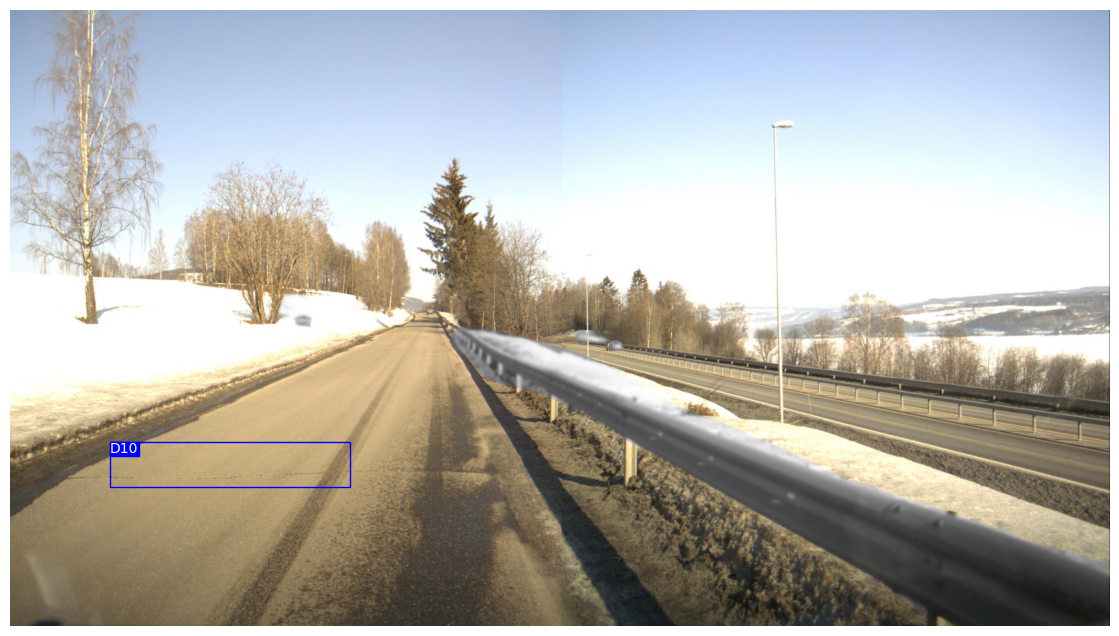

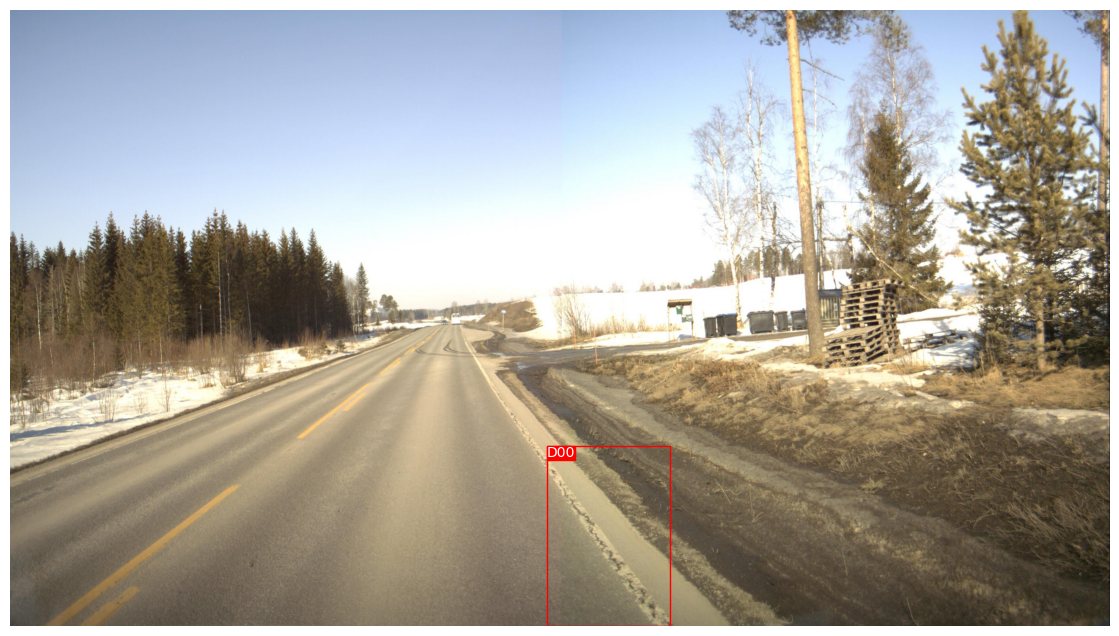

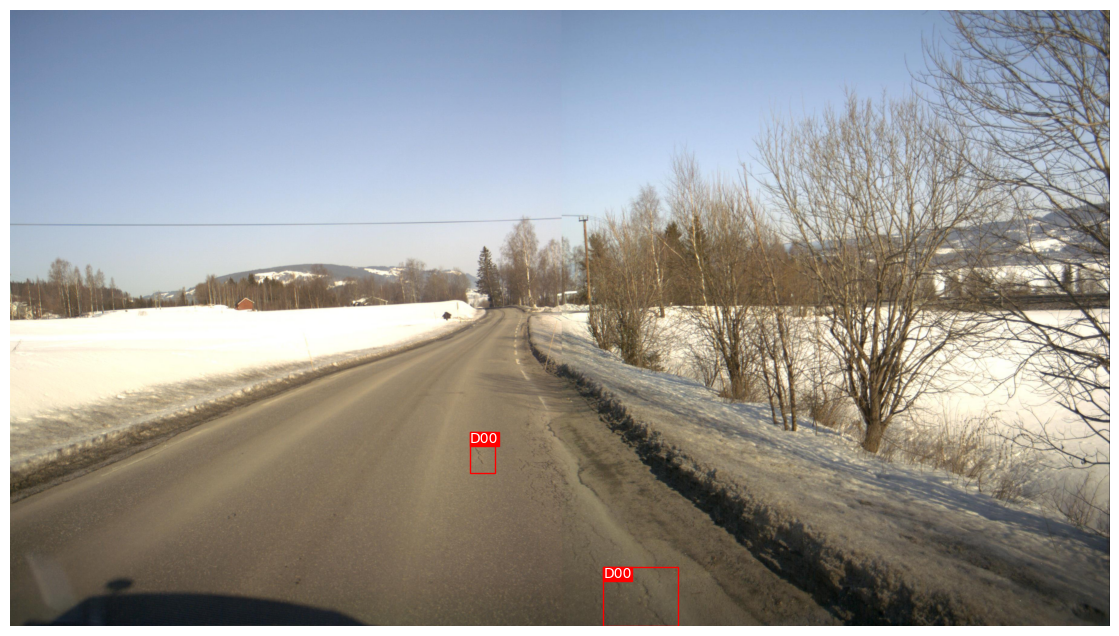

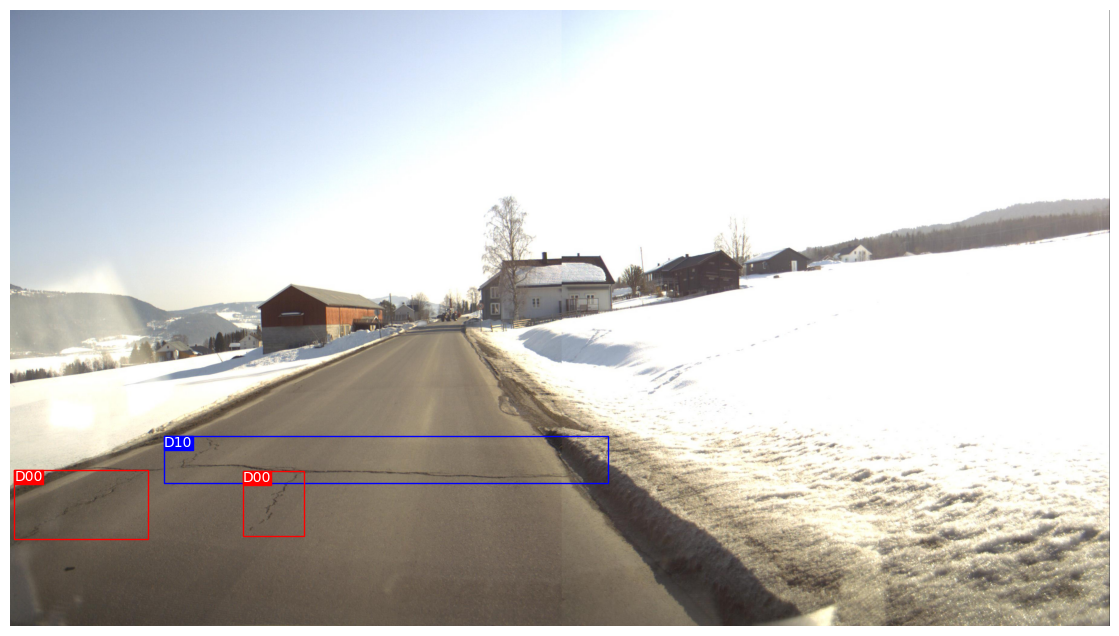

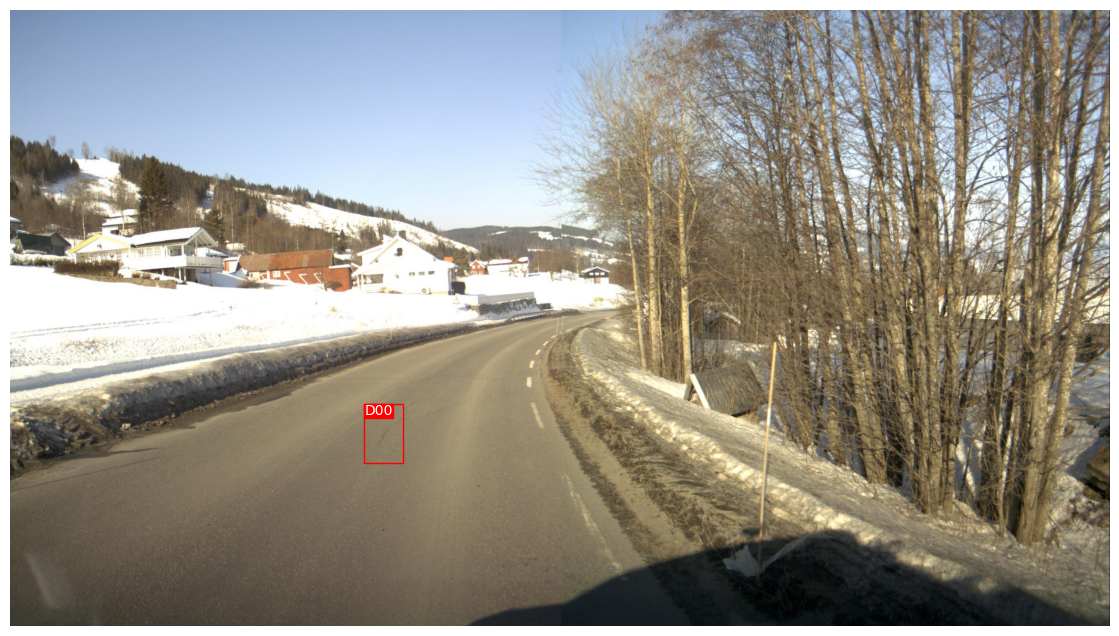

In [83]:
predictions = random.choices([x for x in output_dicts if len(x["bboxes"]) > 0] , k=5)

class_colors = {
    0: "red",
    1: "blue",
    2: "purple",
    3: "green",
}
for prediction in predictions:
    image_path = images_dir + "/" + prediction["image"]
    image = Image.open(image_path)
    image_width, image_height = image.size
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for bbox in prediction["bboxes"]:
        xmin, ymin, xmax, ymax = upscale_bbox_corners(bbox, image_width, image_height)
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor=class_colors[bbox["type"]],
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            xmin,
            ymin,
            class_names[bbox["type"]],
            color="white",
            verticalalignment="top",
            bbox={"color": class_colors[bbox["type"]], "pad": 0},
        )
    ax.imshow(image)
    plt.axis("off")
    plt.show()
    


### Discussion

This section will hopefully give some keener insight on how to improve the model in the future, and what we could have
done better - had we both had more time, and more knowledge about the subject.

**To few cracks in the `D20` and `D40`**<br>
First, a key takeaway we saw early was that the model seems to unwilling to predict that cracks belong to the `D20` 
and `D40` classes. This is probably due to the fact that the model is trained on a dataset with a lot of `D10` and `D00` 
cracks, and not so many of theother classes. They are also more often than not very small, or very far away in the image.
A way to circumvent this would be to use a dataset with more of the other classes, or to augment the dataset with more of 
the other classes. This would probably improve the model's performance on the `D20` and `D40` classes. Below we plot the 
distribution of the classes in the training set, and the predicted test set. 

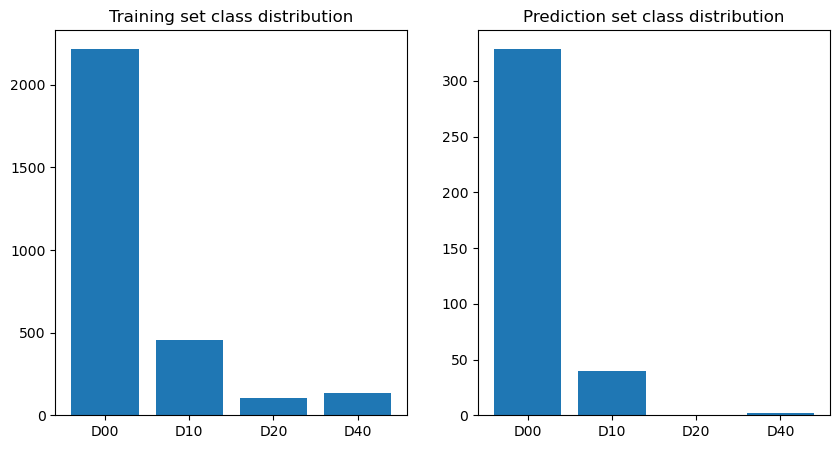

In [62]:
train_data_ann_path = "./Norway/train/annotations/xmls"
train_data_ann = os.listdir(train_data_ann_path)
train_data_ann = [x for x in train_data_ann if x.endswith(".txt")]

# Fetching list of all classes in training set
train_data_ann = [open(os.path.join(train_data_ann_path, train_data_ann[i]), "r").readline().split()[0] 
                    for i in range(len(train_data_ann)) if open(os.path.join(train_data_ann_path, train_data_ann[i]), "r").readline() != ""]

# Creating a dictionary of class distribution in training set
train_data_ann_dict = {"0": 0, "1": 0, "2": 0, "3": 0}
for i in train_data_ann:
        train_data_ann_dict[i] += 1


# Do the same for prediction set
pred_data_ann_path = "./yolov5/runs/detect/exp/labels"
pred_data_ann = os.listdir(pred_data_ann_path)
pred_data_ann = [x for x in pred_data_ann if x.endswith(".txt")]

pred_data_ann = [open(os.path.join(pred_data_ann_path, pred_data_ann[i]), "r").readline().split()[0] 
                    for i in range(len(pred_data_ann)) if open(os.path.join(pred_data_ann_path, pred_data_ann[i]), "r").readline() != ""]


pred_data_ann_dict = {"0": 0, "1": 0, "2": 0, "3": 0}
for i in pred_data_ann:
    pred_data_ann_dict[i] += 1


# Plotting the distributions beside each other with xticks being class names
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(train_data_ann_dict.keys(), train_data_ann_dict.values())
ax[0].set_xticks(list(train_data_ann_dict.keys()))
ax[0].set_xticklabels([class_names[int(x)] for x in train_data_ann_dict.keys()])
ax[0].set_title("Training set class distribution")
ax[1].bar(pred_data_ann_dict.keys(), pred_data_ann_dict.values())
ax[1].set_xticks(list(pred_data_ann_dict.keys()))
ax[1].set_xticklabels([class_names[int(x)] for x in pred_data_ann_dict.keys()])
ax[1].set_title("Prediction set class distribution")
plt.show()




**Hyperparameter tuning**<br>
As time was limited, learning the data and the models was prioritized over hyperparameter tuning. For future work, it would
be interesting to see how the model performs with different hyperparameters, and if it is possible to improve the model
by tuning the hyperparameters. This could be things like learning rate, batch size, number of epochs, image size and so on. 
YOLO is a very popular model, and there are a lot of resources on how to tune it.

**Other models**<br>
Before deciding to go with YOLO, we did try to make our own version of Faster R-CNN, but we were not able to get it to work
as we wanted. But, trying other models and comparing them to YOLO would be interesting. The scrap code for this model
can be viewed (at your own risk) in `deprecated.ipynb`.

**Color matching**<br>
The model is trained on images with a lot of different colors. One could try to match the colors of the images in the
training set to the colors of the images in the test set, to see if this improves the model's performance.
We were not able to do this.